In [1]:
import os
from astropy.table import Table
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import fitsio
%matplotlib inline

In [2]:
import desisim
import desisurvey
import desimodel.io
import desimodel.footprint

# Environment Variables 

Set some environment variables and create output directories

`$DESISURVEY` = `${SCRATCH}`/quicksurvey_example/survey/

In [3]:
basedir = os.path.join(os.getenv('SCRATCH'),'quicksurvey_example')
surveydir = os.environ['DESISURVEY'] = os.path.join(basedir,'survey')
print(os.environ['DESISURVEY'])

/global/cscratch1/sd/forero/quicksurvey_example/survey


In [4]:
targetdir = os.path.join(basedir,'targets')
zcatbrightdir = os.path.join(basedir,'zcat/bright')
zcatdarkdir = os.path.join(basedir,'zcat/dark')
os.makedirs(targetdir, exist_ok=True)
os.makedirs(zcatbrightdir, exist_ok=True)
os.makedirs(zcatdarkdir, exist_ok=True)

# Survey Plan
We create a list of tiles to be observed by running `surveyplan` and `surveysim` for the whole survey.
We used the following script

In [5]:
!cat  ./survey/surveysim_HA.sh

#!/bin/bash
#############################################################################
# Example automation for cycling between surveyplan and surveysim using
# a greedy scheduling algorithm for the next tile selector. Since the
# greedy scheduler does not use hour-angle assignments, surveyplan is
# relatively fast since no hour-angle optimization is required. The total
# time to run a 5-year survey with this script is about 45 minutes.
#############################################################################

export DESISURVEY=${SCRATCH}'/quicksurvey_example/survey'

PLAN_ARGS='--verbose --nopt 0'
SIM_ARGS='--verbose --seed 123 --strategy HA+fallback --plan plan.fits'

surveyplan --create ${PLAN_ARGS}
surveysim ${SIM_ARGS}

while :
do
    (surveyplan ${PLAN_ARGS}) || break
    (surveysim --resume ${SIM_ARGS}) || break
done


This takes almost one hour to run. 
If you don't want to run it, you can skip to **Run Select Mock Targets**

In [6]:
# ! ./survey/surveysim_HA.sh

# Read exposures list
Select a subset of tiles in the NGC selected to have dark, gray, and bright while excluding bright twilight tiles since our sky model doesn't know about twilight yet.

In [10]:
tiles = desimodel.io.load_tiles()
explist = Table.read(surveydir+'/exposures.fits')
isbright = explist['pass'] > 4
isgray = explist['pass'] == 4
isdark = explist['pass'] < 4
istwilight = isbright & (explist['moonalt'] < 0)

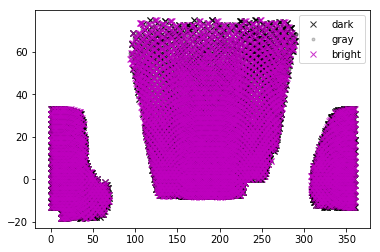

In [11]:
plt.plot(explist['ra'][isdark], explist['dec'][isdark], 'kx', alpha=0.8, label='dark')
plt.plot(explist['ra'][isgray], explist['dec'][isgray], 'k.', alpha=0.2, label='gray')
plt.plot(explist['ra'][isbright], explist['dec'][isbright], 'mx', alpha=0.8, label='bright')
plt.legend(loc='upper right')

Pick 10 tiles nearest RA=130, dec=18

In [12]:
ntiles = 10
xtiles = tiles[np.in1d(tiles['TILEID'], explist['tileid'])]
xyz = hp.ang2vec(xtiles['ra'], xtiles['dec'], lonlat=True)
center = hp.ang2vec(130, 18, lonlat=True)
d2 = ((xyz - center)**2).sum(axis=1)
ii = np.argsort(d2)[0:ntiles]
xtiles = xtiles[ii]
nside = 64
pixels = desimodel.footprint.tiles2pix(nside, xtiles)
nexp = np.count_nonzero(np.in1d(explist['tileid'], xtiles['TILEID']) & ~istwilight)
print('{} tiles covered by {} exposures and {} healpixels'.format(len(xtiles), nexp, len(pixels)))

10 tiles covered by 14 exposures and 48 healpixels


In [13]:
#- row indices of exposures of the selected tiles
iobs = np.where(np.in1d(explist['tileid'], xtiles['TILEID']))[0]
assert np.all(np.in1d(explist['tileid'][iobs], xtiles['TILEID']))
print(iobs)
print(pixels, len(pixels))
explist[iobs]

[1269 1270 1588 1589 1927 1928 2210 2212 3910 5697 6017 6018 7308 7309 7969
 7970]
[4329 4330 4331 4332 4333 4334 4335 4346 4629 4631 4637 4672 4673 4674 4675
 4676 4677 4678 4679 4680 4681 4682 4683 4684 4685 4686 4687 4688 4689 4690
 4691 4694 4696 4697 4698 4699 4700 4702 4705 4708 4709 4710 4711 4720 4721
 4722 4723 4724] 48


tileid,pass,ra,dec,night,mjd,exptime,seeing,airmass,moonfrac,moonalt,moonsep
,,,,,,s,arcsec,,,deg,deg
int32,int16,float64,float64,str10,float64,float64,float64,float64,float64,float64,float64
28356,4,131.17,18.02,2019-10-25,58782.4899558,752.154167716,0.84192687273,1.18616961764,0.0520627337917,1.34655475616,62.1605676335
28356,4,131.17,18.02,2019-10-25,58782.5000502,991.484783048,0.84192687273,1.18616961764,0.0520627337917,1.34655475616,62.1605676335
5327,0,129.59,19.54,2019-11-07,58795.4530125,661.712763623,1.11448824406,1.16538887688,0.834813009158,-11.3683643341,128.110361181
5327,0,129.59,19.54,2019-11-07,58795.4620601,697.226528437,1.11448824406,1.16538887688,0.834813009158,-11.3683643341,128.110361181
5307,0,129.18,16.6,2019-11-25,58813.3874713,738.811032537,0.958591520786,1.25048481576,0.00227809111819,-55.1059379578,114.059502837
5307,0,129.18,16.6,2019-11-25,58813.3974112,839.967161255,0.958591520786,1.25048481576,0.00227809111819,-55.1059379578,114.059502837
34119,5,129.86,19.47,2019-12-06,58824.3500818,515.686169159,1.0380011797,1.2734523425,0.770513548588,15.7024736404,109.739411758
34098,5,129.54,16.49,2019-12-06,58824.3657114,503.644975573,0.947930455208,1.21822021882,0.770513548588,11.6239700317,109.749799781


In [14]:
# save the reduce list of exposures for bright and dark/gray survey
mini_explist = explist[iobs]
isbright = mini_explist['pass'] > 4


exposurefile = os.path.join(surveydir,'exposures_bright.fits')
Table(mini_explist[isbright]).write(exposurefile, overwrite=True)


exposurefile = os.path.join(surveydir,'exposures_dark.fits')
Table(mini_explist[~isbright]).write(exposurefile, overwrite=True)

In [15]:
Table(mini_explist[isbright])

tileid,pass,ra,dec,night,mjd,exptime,seeing,airmass,moonfrac,moonalt,moonsep
,,,,,,s,arcsec,,,deg,deg
int32,int16,float64,float64,str10,float64,float64,float64,float64,float64,float64,float64
34119,5,129.86,19.47,2019-12-06,58824.3500818,515.686169159,1.0380011797,1.2734523425,0.770513548588,15.7024736404,109.739411758
34098,5,129.54,16.49,2019-12-06,58824.3657114,503.644975573,0.947930455208,1.21822021882,0.770513548588,11.6239700317,109.749799781
39860,6,130.63,16.48,2020-04-21,58961.1396662,421.677673327,1.26988720894,1.0823483994,0.00762425522853,-29.0910816193,107.239345079
40476,7,129.32,17.9,2020-10-15,59138.513847,443.12330177,1.44786882401,1.17298482257,0.00602702962842,-11.5951442719,73.337733508


In [16]:
Table(mini_explist[~isbright])

tileid,pass,ra,dec,night,mjd,exptime,seeing,airmass,moonfrac,moonalt,moonsep
,,,,,,s,arcsec,,,deg,deg
int32,int16,float64,float64,str10,float64,float64,float64,float64,float64,float64,float64
28356,4,131.17,18.02,2019-10-25,58782.4899558,752.154167716,0.84192687273,1.18616961764,0.0520627337917,1.34655475616,62.1605676335
28356,4,131.17,18.02,2019-10-25,58782.5000502,991.484783048,0.84192687273,1.18616961764,0.0520627337917,1.34655475616,62.1605676335
5327,0,129.59,19.54,2019-11-07,58795.4530125,661.712763623,1.11448824406,1.16538887688,0.834813009158,-11.3683643341,128.110361181
5327,0,129.59,19.54,2019-11-07,58795.4620601,697.226528437,1.11448824406,1.16538887688,0.834813009158,-11.3683643341,128.110361181
5307,0,129.18,16.6,2019-11-25,58813.3874713,738.811032537,0.958591520786,1.25048481576,0.00227809111819,-55.1059379578,114.059502837
5307,0,129.18,16.6,2019-11-25,58813.3974112,839.967161255,0.958591520786,1.25048481576,0.00227809111819,-55.1059379578,114.059502837
11069,1,130.26,16.58,2020-10-26,59149.4811522,832.240804315,1.1652649641,1.20274839574,0.839739249054,-20.4459514618,139.115188724
11069,1,130.26,16.58,2020-10-26,59149.4921735,738.30554098,1.1652649641,1.20274839574,0.839739249054,-20.4459514618,139.115188724


Plot the tiles and pixels

(13, 23)

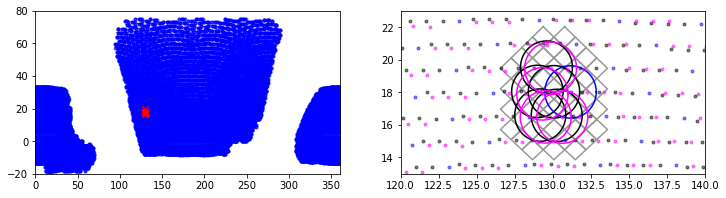

In [17]:
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plt.plot(x,y, '-', color=color)

def plot_healpix(nside, pixels):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        plt.plot(ra, dec, '-', color='0.6')

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(tiles['RA'], tiles['DEC'], 'k,', alpha=0.5)
plt.plot(explist['ra'], explist['dec'], 'b.', alpha=0.5)
plt.plot(xtiles['RA'], xtiles['DEC'], 'rx')
plt.xlim(0,360); plt.ylim(-20, 80)

plt.subplot(122)
plot_healpix(nside, pixels)
color = dict(DARK='black', GRAY='blue', BRIGHT='magenta')
for program in ['DARK', 'GRAY', 'BRIGHT']:
    ii = tiles['PROGRAM'] == program
    plt.plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
    jj = xtiles['PROGRAM'] == program
    for t in xtiles[jj]:
        plot_tile(t['RA'], t['DEC'], color=color[program])

plt.xlim(120, 140); plt.ylim(13, 23)

In [18]:
#- Write subset of tiles table to file for input to mpi_select_mock_targets
tilefile = os.path.join(targetdir,'test-tiles.fits')
Table(xtiles).write(tilefile, overwrite=True)
Table(xtiles)

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
22594,130.08,18.03,3,1,0.0255654,1.06033,2664.73,1.25706,DARK,1
40476,129.32,17.9,7,1,0.0281447,1.06097,2753.01,1.27791,BRIGHT,4
16832,128.99,18.05,2,1,0.0298504,1.06023,2795.41,1.29012,DARK,1
28356,131.17,18.02,4,1,0.0231459,1.06038,2514.4,1.23876,GRAY,2
11069,130.26,16.58,1,1,0.0251414,1.06783,2711.23,1.26491,DARK,1
34119,129.86,19.47,5,1,0.0294588,1.05365,2734.11,1.27707,BRIGHT,4
34098,129.54,16.49,5,1,0.0278805,1.06832,2785.71,1.28691,BRIGHT,4
5327,129.59,19.54,0,1,0.030104,1.05335,2789.07,1.28163,DARK,1
5307,129.18,16.6,0,1,0.0287025,1.06772,2804.48,1.29245,DARK,1


# Run select_mock_targets

In [19]:
configfile = os.path.join(targetdir,'select-mock-targets.yaml')
os.environ['MPICH_GNI_FORK_MODE'] = 'FULLCOPY'
os.environ['KMP_AFFINITY'] = 'disabled'
os.environ['OMP_NUM_THREADS'] = '1'
cmd = "srun -N 15 -n 30 -c 16 -p debug -C haswell -t 00:30:00"
cmd += " mpi_select_mock_targets -O {targetdir} --config {configfile}"
cmd += " --seed 1 --nproc 16 --nside 64 --tiles {tilefile}"
cmd = cmd.format(targetdir=targetdir, tilefile=tilefile, configfile=configfile)
print(cmd)

srun -N 15 -n 30 -c 16 -p debug -C haswell -t 00:30:00 mpi_select_mock_targets -O /global/cscratch1/sd/forero/quicksurvey_example/targets --config /global/cscratch1/sd/forero/quicksurvey_example/targets/select-mock-targets.yaml --seed 1 --nproc 16 --nside 64 --tiles /global/cscratch1/sd/forero/quicksurvey_example/targets/test-tiles.fits


In [20]:
#!$cmd

In [21]:
cmd = "join_mock_targets --mockdir {} --force".format(targetdir)
print(cmd)
!$cmd

join_mock_targets --mockdir /global/cscratch1/sd/forero/quicksurvey_example/targets --force
INFO:build.py:932:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/sky.fits
INFO:build.py:932:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/standards-dark.fits
INFO:build.py:932:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/standards-bright.fits
INFO:build.py:932:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/targets.fits
INFO:build.py:932:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/truth.fits
INFO:build.py:1004:join_targets_truth: Generating merged target list /global/cscratch1/sd/forero/quicksurvey_example/targets/mtl.fits
DEBUG: before targets.calc_priority slow copy
DEBUG: seconds for targets.calc_priority slow copy: 0.061083078384399414
DEBUG: calc_priority has 277778 unobserved targets
0 of 277778 targets have

In [22]:
# some sanity checks on the results

In [23]:
targets = fitsio.read(targetdir+'/targets.fits')
truth   = fitsio.read(targetdir+'/truth.fits')
mtl     = fitsio.read(targetdir+'/mtl.fits')
std     = fitsio.read(targetdir+'/standards-dark.fits')
sky     = fitsio.read(targetdir+'/sky.fits')

In [24]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))

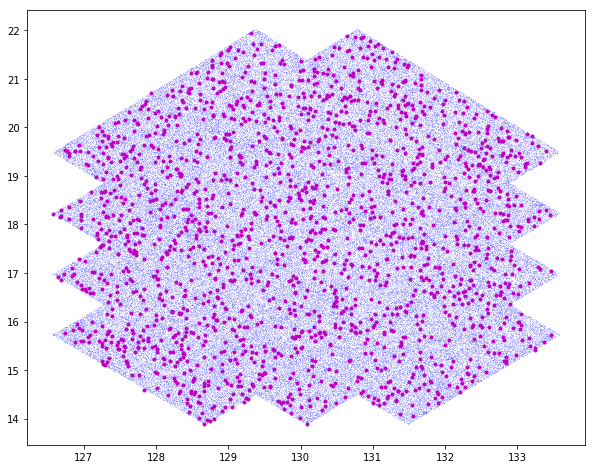

In [25]:
plt.figure(figsize=(10,8))
plt.plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)
plt.plot(std['RA'], std['DEC'], 'm.')

# Run quicksurvey

Requires this [PR](https://github.com/desihub/desisim/pull/249) (branch `surveysim_epochs`)

In [28]:
quicksurvey_cmd = "quicksurvey -T targets/ -E {exposures}  --output_dir {outputdir} -f $(which fiberassign)"
quicksurvey_cmd += " -t {fiberassign_template} -D {fiberassign_dates}"

cmd = quicksurvey_cmd.format(exposures='survey/exposures_bright.fits', 
                             outputdir=zcatbrightdir, 
                             fiberassign_template='fiberassign/template_fiberassign_bright.txt', 
                            fiberassign_dates='fiberassign/fiberassign_dates_bright.txt')
print(cmd)

!$cmd

quicksurvey -T targets/ -E survey/exposures_bright.fits  --output_dir /global/cscratch1/sd/forero/quicksurvey_example/zcat/bright -f $(which fiberassign) -t fiberassign/template_fiberassign_bright.txt -D fiberassign/fiberassign_dates_bright.txt
['2019-12-06', '2020-02-01', '2020-08-01', '9999-99-99']
tiles in epoch 0 [2019-12-06 to 2020-02-01]: 2
tiles in epoch 1 [2020-02-01 to 2020-08-01]: 1
tiles in epoch 2 [2020-08-01 to 9999-99-99]: 1
['TARGETID', 'MOCKID', 'CONTAM_TARGET', 'TRUEZ', 'TRUESPECTYPE', 'TEMPLATETYPE', 'TEMPLATESUBTYPE', 'TEMPLATEID', 'SEED', 'MAG', 'DECAM_FLUX', 'WISE_FLUX', 'OIIFLUX', 'HBETAFLUX', 'TEFF', 'LOGG', 'FEH']
--- Epoch 0 ---
Tue Aug  1 09:54:39 2017 Starting MTL
DEBUG: before targets.calc_priority slow copy
DEBUG: seconds for targets.calc_priority slow copy: 0.07630157470703125
DEBUG: calc_priority has 277778 unobserved targets
0 of 277778 targets have priority zero, setting N_obs=0.
Tue Aug  1 09:54:41 2017 Finished MTL
2 tiles to be included in fiberassig

In [29]:
cmd = quicksurvey_cmd.format(exposures='survey/exposures_dark.fits', 
                             outputdir=zcatdarkdir, 
                             fiberassign_template='fiberassign/template_fiberassign_dark.txt', 
                            fiberassign_dates='fiberassign/fiberassign_dates_dark.txt')
print(cmd)

!$cmd

quicksurvey -T targets/ -E survey/exposures_dark.fits  --output_dir /global/cscratch1/sd/forero/quicksurvey_example/zcat/dark -f $(which fiberassign) -t fiberassign/template_fiberassign_dark.txt -D fiberassign/fiberassign_dates_dark.txt
['2019-10-25', '2020-02-01', '2020-12-01', '9999-99-99']
tiles in epoch 0 [2019-10-25 to 2020-02-01]: 3
tiles in epoch 1 [2020-02-01 to 2020-12-01]: 1
tiles in epoch 2 [2020-12-01 to 9999-99-99]: 2
['TARGETID', 'MOCKID', 'CONTAM_TARGET', 'TRUEZ', 'TRUESPECTYPE', 'TEMPLATETYPE', 'TEMPLATESUBTYPE', 'TEMPLATEID', 'SEED', 'MAG', 'DECAM_FLUX', 'WISE_FLUX', 'OIIFLUX', 'HBETAFLUX', 'TEFF', 'LOGG', 'FEH']
--- Epoch 0 ---
Tue Aug  1 09:55:20 2017 Starting MTL
DEBUG: before targets.calc_priority slow copy
DEBUG: seconds for targets.calc_priority slow copy: 0.07910776138305664
DEBUG: calc_priority has 277778 unobserved targets
0 of 277778 targets have priority zero, setting N_obs=0.
Tue Aug  1 09:55:23 2017 Finished MTL
3 tiles to be included in fiberassign
Tue Au